# Example to calculate photon-ALP oscillations from NGC 1275

This notebook demonstrates how to calculate the photon-ALP transition probability for NGC 1275, the central AGN of the Perseus cluster. The assumed B-field environments are the same as in Ajello et al. (2016), http://inspirehep.net/record/1432667, and include the cluster field and the magnetic field of the Milky Way. 

In [1]:
from gammaALPs import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from ebltable.tau_from_model import OptDepth
from astropy import constants as c
from myplot.funcs import *

In [2]:
%matplotlib inline

### Set the ALP

Initialize an ALP object, that stores the ALP mass $m$ (in neV) and the coupling $g$ (in $10^{-11}\mathrm{GeV}^{-1}$).

In [3]:
m, g = 1.,1.
alp = ALP(m,g)

## Set the source

Set the source properties (redshift and sky coordinates) in the ```Source``` containier

In [4]:
ngc1275 = Source(z = 0.017559, ra = '03h19m48.1s', dec = '+41d30m42s')
print ngc1275.z
print ngc1275.ra, ngc1275.dec
print ngc1275.l, ngc1275.b

0.017559
-13.2613435443 41.5116666667
150.575674321 -13.2613435443


### Init the module list

Initialize the list of transfer modules that will store the different magnetic field environments. 

Energies are supplied in GeV as ```numpy.ndarray```

In [5]:
EGeV = np.logspace(1.,5.,200)

Now initialize the initial photon polarization. Since we are dealing with a gamma-ray source, no ALPs are initially present in the beam (third diagonal element is zero). The polarization density matrix is normalized such that its trace is equal to one, $\mathrm{Tr}(\rho_\mathrm{in}) = 1$.

In [6]:
pin = np.diag((1.,1.,0.)) * 0.5

In [7]:
m = ModuleList(alp, ngc1275, pin = pin, EGeV = EGeV)

### Add modules:

Now we add propagation modules for the cluster, the EBL, and the Galactic magnetic field.

In [8]:
m.add_propagation("ICMGaussTurb", 
                  0, # position of module counted from the source. 
                  nsim = 10, # number of random B-field realizations
                  B0 = 10.,  # rms of B field
                  n0 = 39.,  # normalization of electron density
                  n2 = 4.05, # second normalization of electron density, see Churazov et al. 2003, Eq. 4
                  r_abell = 500., # extension of the cluster
                  r_core = 80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4
                  r_core2 = 280., # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta = 1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta2= 0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                  eta = 0.5, # scaling of B-field with electron denstiy
                  kL = 0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012 
                  kH = 9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  q = -2.80 # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                 )
m.add_propagation("EBL",1, model = 'dominguez') # EBL attenuation comes second, after beam has left cluster
m.add_propagation("GMF",2, model = 'jansson12', model_sum = 'ASS') # finally, the beam enters the Milky Way Field

We can also change the ALP parameters before running the modules:

In [9]:
m.alp.m = 50.
m.alp.g = 0.5

### Run all modules

Now we run the modules. If ```multiprocess``` key word is larger than two, this will be split onto multiple cores with python's ```multiprocess``` module.

The ```px,py,pa``` variables contain the mixing probability into the two photon polarization states (x,y) and into the axion state (a).

In [10]:
px,py,pa = m.run(multiprocess=2)

## Plot the output 

(10, 200)
0.00105948398812
0.00195688165622


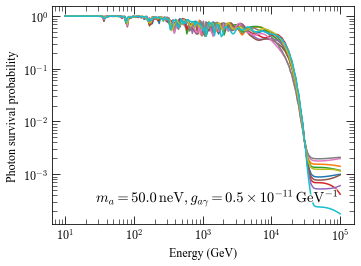

In [20]:
pgg = px + py # the total photon survival probability

print pgg.shape
print np.min(np.median(pgg, axis = 0))
print np.min(np.max(pgg, axis = 0))

for p in pgg: # plot all realizations
    plt.semilogx(m.EGeV, p)

plt.xlabel('Energy (GeV)')
plt.ylabel('Photon survival probability')
plt.legend(loc = 0, fontsize = 'medium')

plt.annotate(r'$m_a = {0:.1f}\,\mathrm{{neV}}, g_{{a\gamma}} = {1:.1f} \times 10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$'.format(m.alp.m,m.alp.g),
             xy = (0.95,0.1), size = 'x-large', xycoords = 'axes fraction', ha = 'right',**effect)

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.subplots_adjust(left = 0.2)

# Save results

Save the results in an astropy table. 

In [12]:
from astropy.table import Table

In [26]:
c = {}
c['pgg'] = np.vstack((EGeV, pgg))
t = Table(c)

In [27]:
t.write('ngc1275.fits', overwrite = True)

In [28]:
t1 = Table.read('ngc1275.fits')

In [29]:
t1

pgg [200]
float64
10.0 .. 100000.0
0.999994276333 .. 0.000995460713466
0.999998066282 .. 0.00140765250317
0.999999506494 .. 0.00117846054873
0.999993558293 .. 0.000415746924837
0.999992702587 .. 0.000606051955945
0.999999661097 .. 0.000969089766071
1.00000027627 .. 0.00197590901733
0.999997259008 .. 0.00208775558636


### Plot the magnetic field of the cluster, stored in module 0

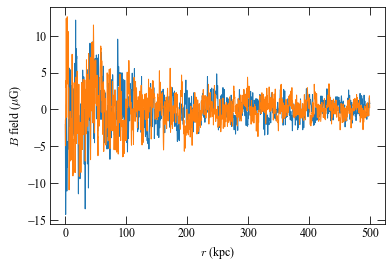

In [17]:
plt.plot(m.modules[0]._r,m.modules[0]._B * np.sin(m.modules[0].psi),
         lw = 1)
plt.plot(m.modules[0]._r,m.modules[0]._B * np.cos(m.modules[0].psi),
         lw = 1) 
plt.ylabel('$B$ field ($\mu$G)')
plt.xlabel('$r$ (kpc)')

And plot the electron density:

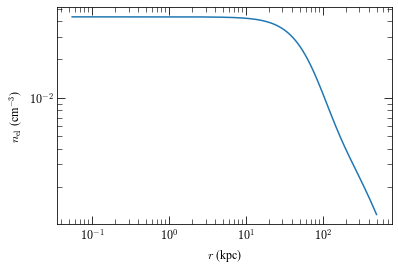

In [18]:
plt.loglog(m.modules[0]._r,m.modules[0]._nel * 1e-3)
plt.ylabel('$n_\mathrm{el}$ (cm$^{-3}$)')
plt.xlabel('$r$ (kpc)')

### Plot the magnetic field of the Milky Way, stored in module 2

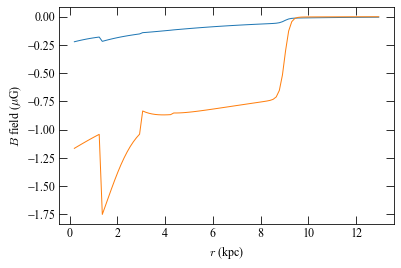

In [19]:
plt.plot(m.modules[2]._r,m.modules[2]._B * np.sin(m.modules[2].psi),
         lw = 1)
plt.plot(m.modules[2]._r,m.modules[2]._B * np.cos(m.modules[2].psi),
         lw = 1) 
plt.ylabel('$B$ field ($\mu$G)')
plt.xlabel('$r$ (kpc)')